### Identify cause of convection

Next: look into to what extent offshore CDW properties are changing causing the problems or whether CDW transport/supply changes to the Weddell Sea could explain it

- look at U, V horizontal heat transport estimates
- look at T-S diagram endmembers

Is the cooling of the WDW (warm deep water) layer just a result of the convection that happens or does it precede it?

In [2]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import weddell_convect, ross_convect

In [3]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'

## Vertical heat diffusivities

In [4]:
# regions:
weddell_basin      = {'x': slice(950, 1150, None), 'y': slice(295, 360, None)} # very similar to weddell convect but withwout shelf edge
weddell_west_shelf = {'x': slice(918, 967, None), 'y': slice(245, 310, None)}
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}

Look at what happens just at the shelfbreak:

In [5]:
def extract_region_var(run_dir, var_name, region, file_slice=(0,None), file_type='grid_T'):
    if file_type=='grid_W': 
        name_remapping1 = {'nav_lev':'depthw'}
        mask = 'tmask'
    elif file_type=='grid_T':
        name_remapping1 = {'nav_lev':'deptht'}
        mask = 'tmask'
    elif file_type=='grid_U': mask = 'umask'; name_remapping1={'nav_lev':'depthu'};
    elif file_type=='grid_V': mask = 'vmask'; name_remapping1={'nav_lev':'depthv'};

    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename(name_remapping1)
    
    files = glob.glob(f'{run_dir}eANT025*{file_type}*')[file_slice[0]:file_slice[1]]

    area_name='area'
    if file_type=='grid_T': area_name = 'area_grid_T'; name_remapping2 = {'area_grid_T':'area', 'x_grid_T':'x', 'y_grid_T':'y'}
    else: name_remapping2={} 
        
    kwags={'preprocess':lambda ds: ds[[var_name, area_name, 'time_counter']], 'chunks':'auto'}
    nemo_ds    = xr.open_mfdataset(files, **kwags).rename(name_remapping2)
    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = nemo_ds['area'].isel(time_counter=0).expand_dims({name_remapping1['nav_lev']:nemo_ds[name_remapping1['nav_lev']]})
    area_ocean = xr.where(nemo_mesh_ds[mask].values==0, np.nan, area_ocean)
    var_ocean  = xr.where(nemo_mesh_ds[mask].values==0, np.nan, nemo_ds[var_name])
    var_ocean  = xr.where(var_ocean==0, np.nan, var_ocean)

    region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    region_var = xr.where(region_var==0, np.nan, region_var)

    return region_var, var_ocean

In [6]:
def plot_hovmoeller(region_var, ylim=(1600, 0), vmin=0, vmax=1e-2, cmap=cmocean.cm.haline, grid_type='T'):

    if grid_type=='T': depth='deptht'
    elif grid_type=='W': depth='depthw'
    elif grid_type=='U': depth='depthu'
    elif grid_type=='V': depth='depthv'

    fig, ax = plt.subplots(1,1, figsize=(18,5))
    xx, yy = np.meshgrid(region_var.time_counter, region_var[depth])
    
    cb = ax.pcolormesh(xx.transpose(), yy.transpose(), region_var, vmin=vmin, vmax=vmax, cmap=cmap)
    
    fig.colorbar(cb, ax=ax)
    ax.set_ylim(ylim[0], ylim[1])

    return fig, ax

In [7]:
run_dir = f'{base_dir}output/ERA5_test6_highres/files2/'
time_slice=(110,130)

region = weddell_overall

# weddell_vdiff, vdiff = extract_region_var(run_dir, 'difvho' , region, file_slice=time_slice, file_type='grid_W')
weddell_vdiff, vdiff = extract_region_var(run_dir, 'difvho' , region, file_slice=time_slice, file_type='grid_W')
weddell_bn2  , bn2   = extract_region_var(run_dir, 'bn2'    , region, file_slice=time_slice, file_type='grid_W')
weddell_avt_k, avt_k = extract_region_var(run_dir, 'avt_k'  , region, file_slice=time_slice, file_type='grid_W')
weddell_avt_evd, avt_evd = extract_region_var(run_dir, 'avt_evd'  , region, file_slice=time_slice, file_type='grid_W')
# weddell_avm_evd, avm_evd = extract_region_var(run_dir, 'avm_evd'  , region, file_slice=time_slice, file_type='grid_W')
weddell_ediss_k, ediss_k = extract_region_var(run_dir, 'ediss_k'  , region, file_slice=time_slice, file_type='grid_W')
# weddell_estrat, estrat_k = extract_region_var(run_dir, 'estrat_k' , region, file_slice=time_slice, file_type='grid_W')
# weddell_T, T         = extract_region_var(run_dir, 'thetao' , region, file_slice=time_slice, file_type='grid_T')
# weddell_S, S         = extract_region_var(run_dir, 'so'     , region, file_slice=time_slice, file_type='grid_T')

In [ ]:
weddell_rho = gsw.density.rho(weddell_S, weddell_T, weddell_T.deptht) # nemo_mesh_ds.deptht

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


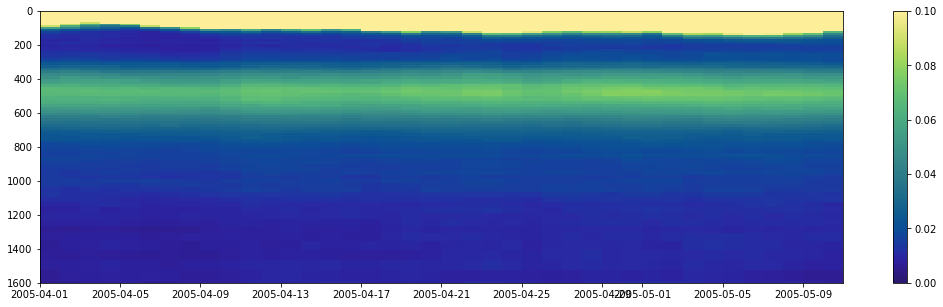

In [8]:
fig1, ax1 = plot_hovmoeller(weddell_vdiff, grid_type='W', vmin=0, vmax=1e-1)

In [ ]:
fig1, ax1 = plot_hovmoeller(weddell_avt_k, grid_type='W', vmin=0, vmax=5e-4)

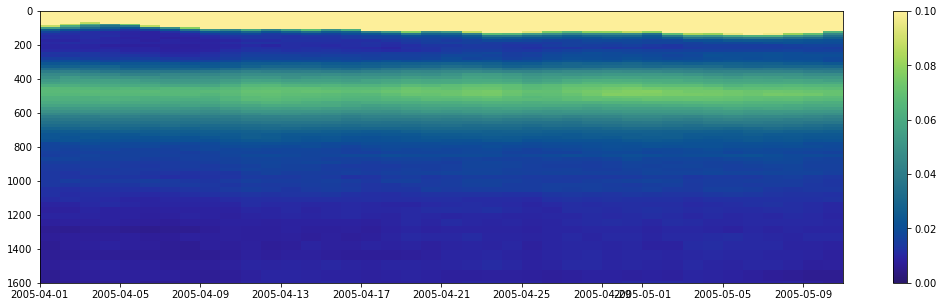

In [13]:
fig1, ax1 = plot_hovmoeller(weddell_avt_evd, grid_type='W', vmin=0, vmax=0.1)

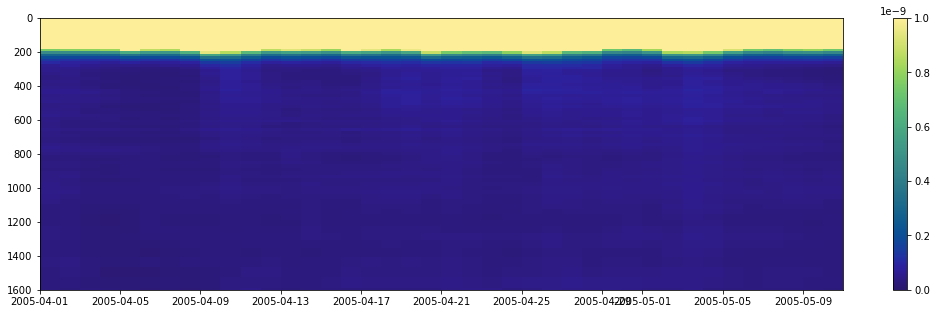

In [16]:
fig1, ax1 = plot_hovmoeller(weddell_ediss_k, grid_type='W', vmin=0, vmax=1e-9)

## Look at daily transect:
- transect from FRIS into the Weddell Sea
- across from peninsula to Maud Rise
- transect from coast to Maud Rise

In [8]:
# ds = xr.open_dataset(f'{run_dir}eANT025.L121_1d_20050101_20051231_grid_W_20050530-20050530.nc')
ds = xr.open_dataset(f'{run_dir}eANT025.L121_1d_20050101_20051231_grid_W_20050801-20050801.nc')

In [26]:
def plot_gridW(ax, ds, var='difvho', sub={'time_counter':0}, kwags={}):

    ds[var].where(ds[var]!=0).isel(**sub).plot(ax=ax, **kwags)
    
    return ax 

def plot_transect(ax, ds, var='difvho', kwags={}, loc='FRIS'):
    # location options: FRIS, peninsula, maud
    if loc=='FRIS': sub={'time_counter':0, 'x':1000, 'y':slice(150, None)}
    elif loc=='peninsula': sub={'time_counter':0, 'x':slice(930,None), 'y':350}
    elif loc=='maud': sub={'time_counter':0, 'x':1360, 'y':slice(300, None)}

    ds[var].where(ds[var]!=0).isel(**sub).plot(ax=ax, **kwags)
    
    return ax

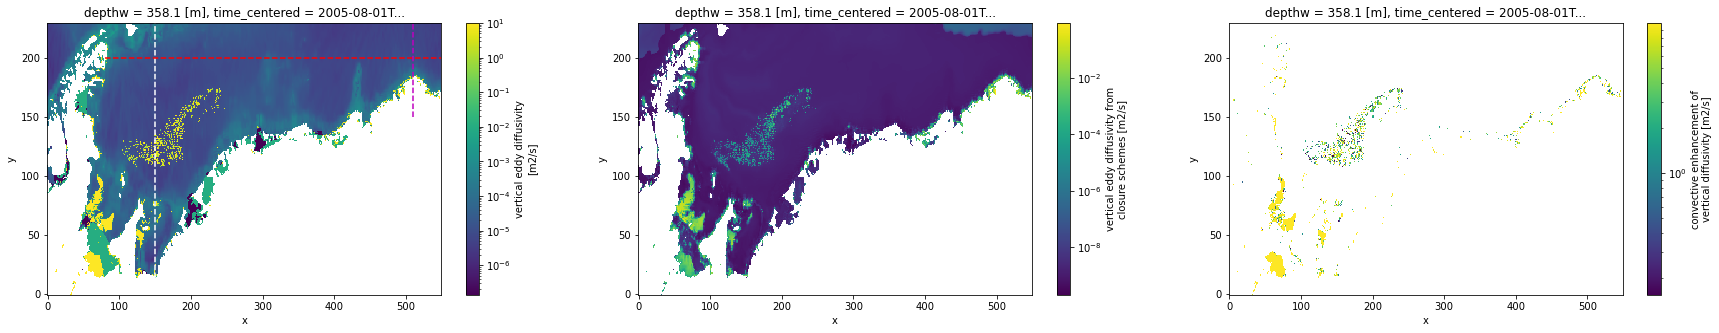

In [22]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))

variables=['difvho', 'avt_k', 'avt_evd']
for v, var in enumerate(variables):
    plot_gridW(ax[v], ds, var=var, sub={'time_counter':0, 'depthw':42, 'x':slice(850,1400), 'y':slice(150,380)}, kwags={'norm':colors.LogNorm()})

ax[0].plot([1000-850, 1000-850], [0,250], '--w')
ax[0].plot([930-850, 1400-850], [200,200], '--r')
ax[0].plot([1360-850, 1360-850], [150,250], '--m')

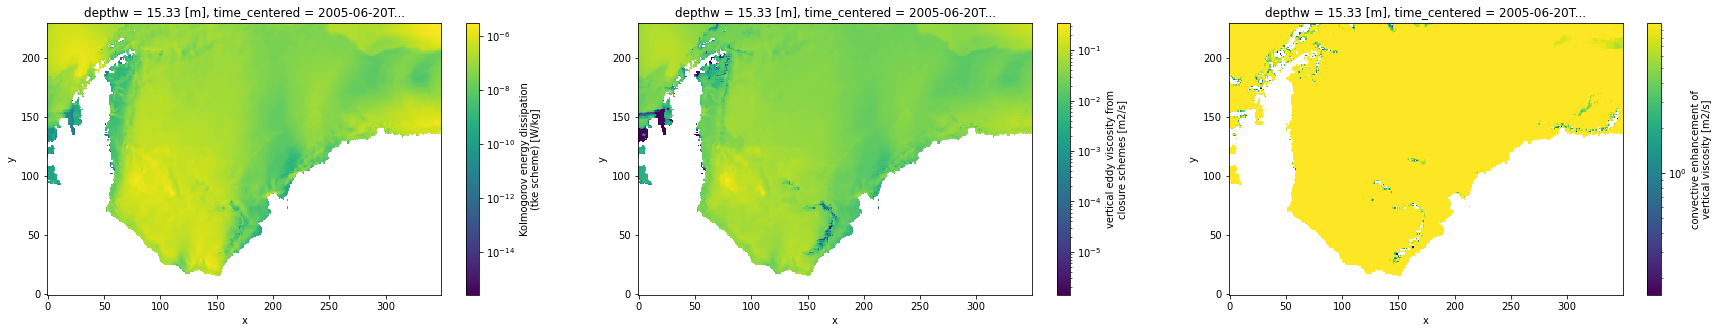

In [119]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))

variables=['ediss_k', 'avm_k', 'avm_evd']
for v, var in enumerate(variables):
    plot_gridW(ax[v], ds, var=var, sub={'time_counter':0, 'depthw':10, 'x':slice(850,1200), 'y':slice(150,380)}, kwags={'norm':colors.LogNorm()})
# ds.estrat_k.where(ds.estrat_k!=0).isel(time_counter=0, depthw=42).plot(ax=ax[0], ylim=(150,380), xlim=(850,1200), vmin=-1e-12, vmax=1e-12)
# ds.ediss_k.where(ds.ediss_k>0).isel(**sub).plot(ax=ax[0], **kwags)

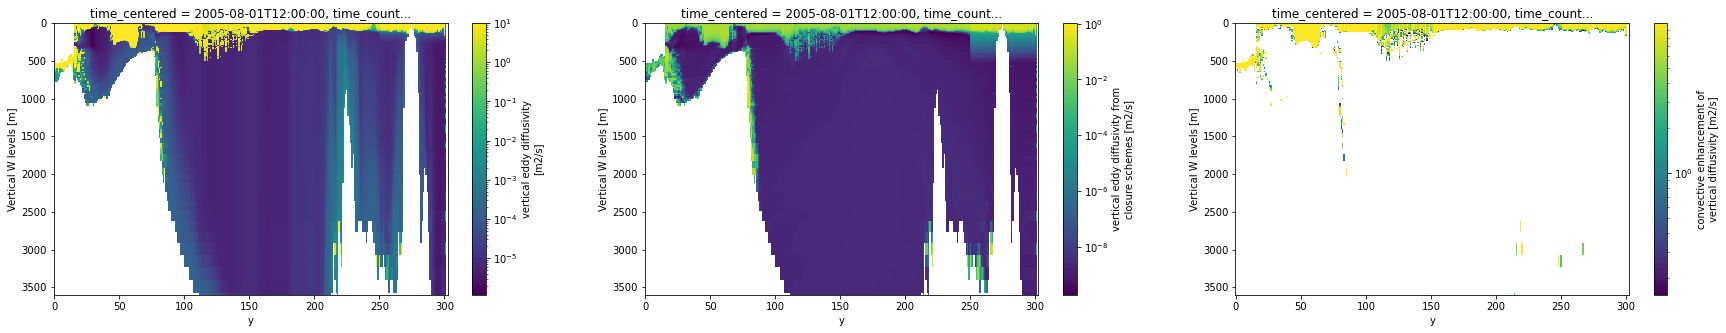

In [24]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))

variables=['difvho', 'avt_k', 'avt_evd']
for v, var in enumerate(variables):
    plot_transect(ax[v], ds, var=var, loc='FRIS', kwags={'norm':colors.LogNorm(), 'ylim':(3600,0)})#, 'xlim':(150,None)})

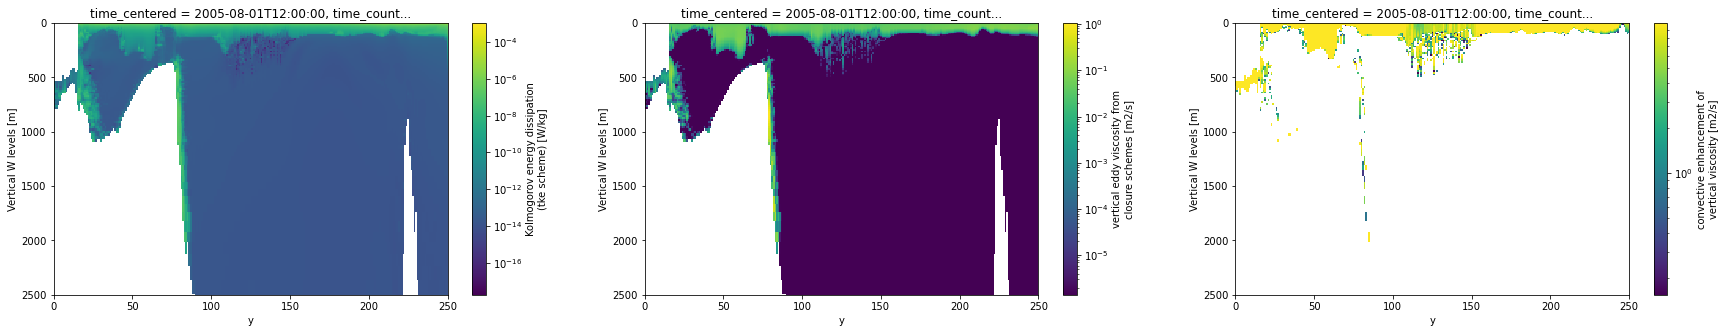

In [35]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))

variables=['ediss_k', 'avm_k', 'avm_evd']
for v, var in enumerate(variables):
    plot_transect(ax[v], ds, var=var, loc='FRIS', kwags={'norm':colors.LogNorm(), 'ylim':(2500,0), 'xlim':(0,250)})

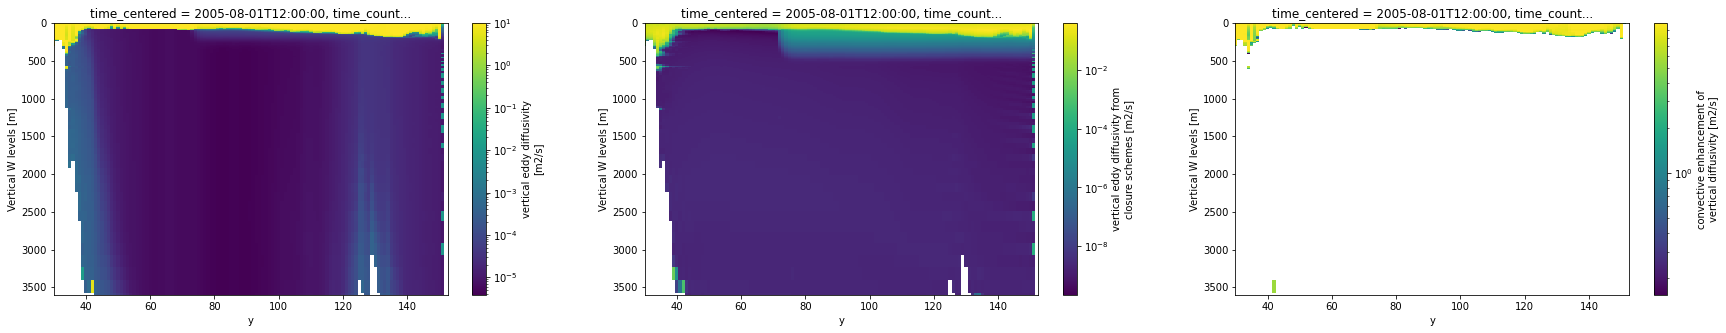

In [28]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))

variables=['difvho', 'avt_k', 'avt_evd']
for v, var in enumerate(variables):
    plot_transect(ax[v], ds, var=var, loc='maud', kwags={'norm':colors.LogNorm(), 'ylim':(3600,0), 'xlim':(30,None)})

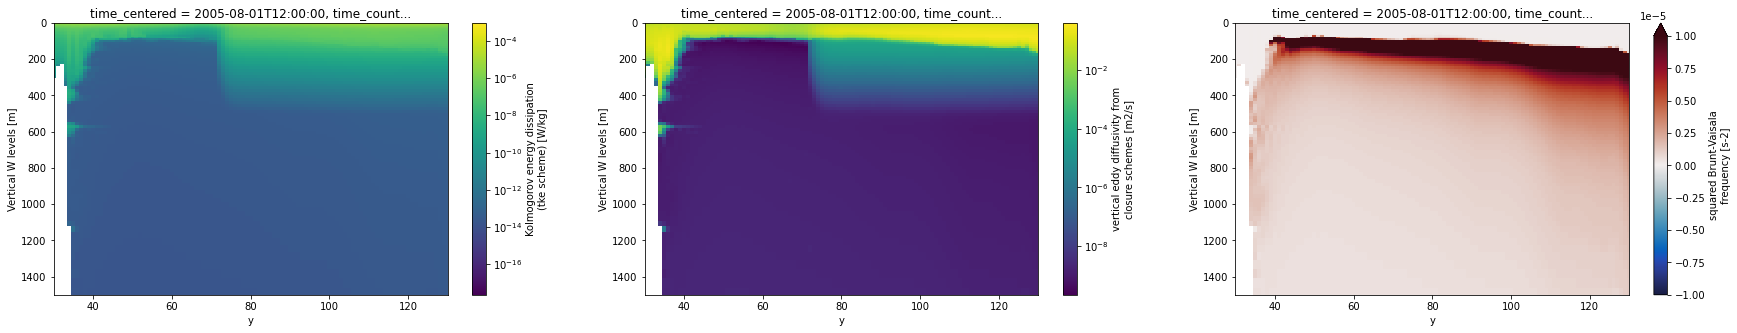

In [46]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))

variables=['ediss_k', 'avt_k', 'bn2']
for v, var in enumerate(variables):
    if v==2: kwags={'ylim':(1500,0), 'xlim':(30,130), 'vmin':-1e-5, 'vmax':1e-5, 'cmap':cmocean.cm.balance}
    else: kwags={'norm':colors.LogNorm(), 'ylim':(1500,0), 'xlim':(30,130)}
    plot_transect(ax[v], ds, var=var, loc='maud', kwags=kwags)

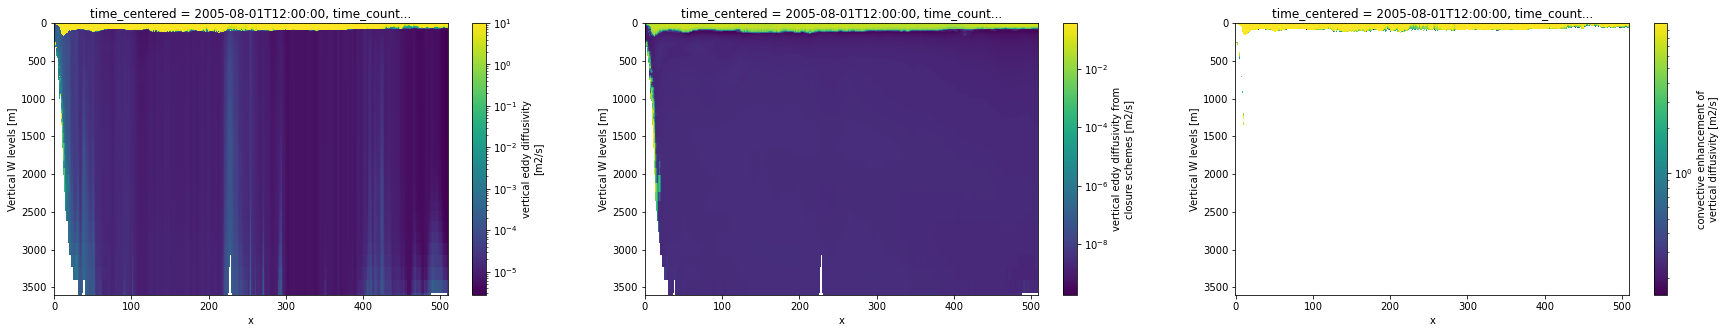

In [29]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))

variables=['difvho', 'avt_k', 'avt_evd']
for v, var in enumerate(variables):
    plot_transect(ax[v], ds, var=var, loc='peninsula', kwags={'norm':colors.LogNorm(), 'ylim':(3600,0)})#, 'xlim':(150,None)})

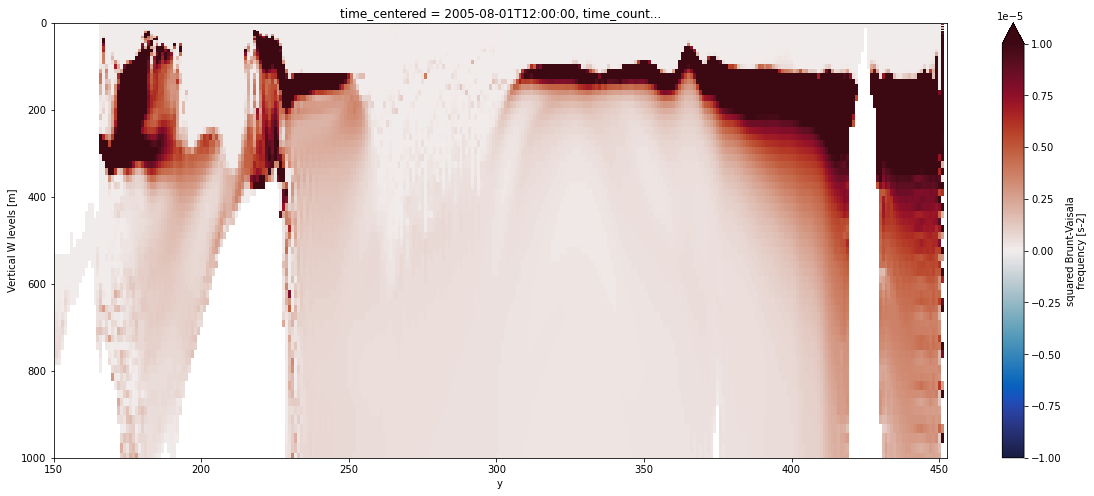

In [31]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))
kwags= {'ylim':(1000,0), 'xlim':(150,None)} #'norm':colors.LogNorm()
sub={'time_counter':0, 'x':1000}
ds.bn2.where(ds.bn2!=0).isel(**sub).plot(ax=ax, vmin=-1e-5, vmax=1e-5, cmap=cmocean.cm.balance, **kwags)

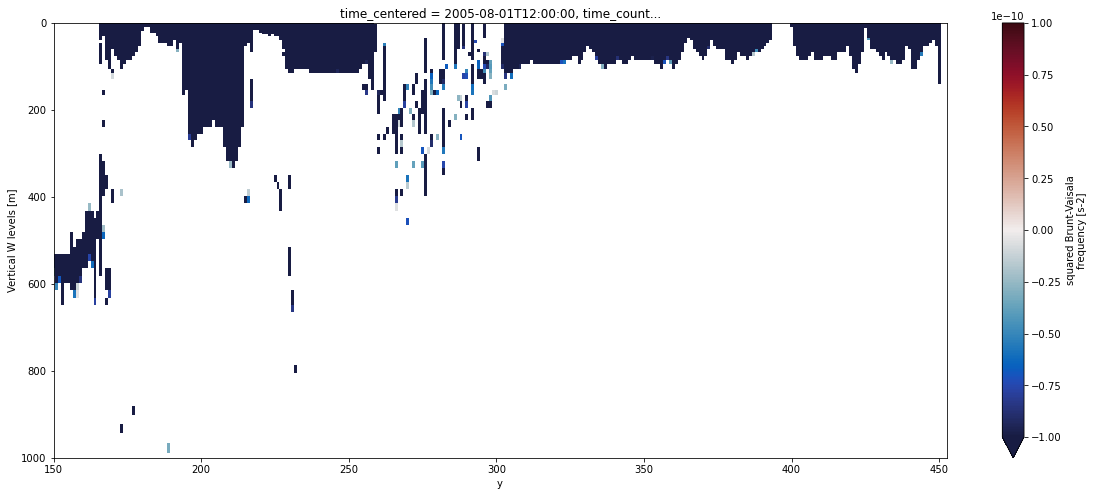

In [32]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))
kwags= {'ylim':(1000,0), 'xlim':(150,None)} #'norm':colors.LogNorm()
sub={'time_counter':0, 'x':1000}
ds.bn2.where(ds.bn2<0).isel(**sub).plot(ax=ax, vmin=-1e-10, vmax=1e-10, cmap=cmocean.cm.balance, **kwags)

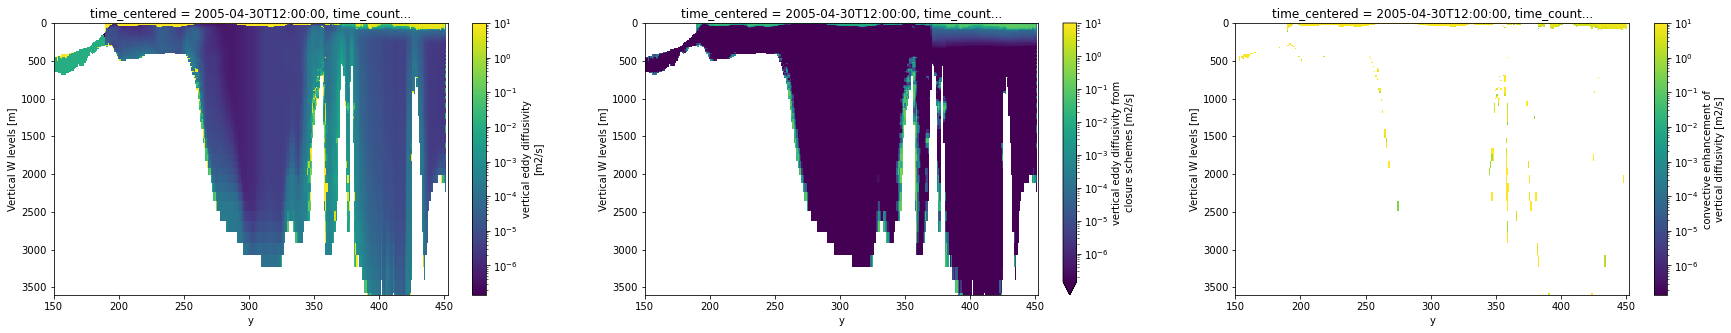

In [59]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))
kwags= {'norm':colors.LogNorm(), 'ylim':(3600,0), 'xlim':(150,None)}
sub={'time_counter':0, 'x':940}
ds.difvho.where(ds.difvho!=0).isel(**sub).plot(ax=ax[0], **kwags)
ds.avt_k.where(ds.avt_k!=0).isel(**sub).plot(ax=ax[1], **kwags)
ds.avt_evd.where(ds.avt_evd!=0).isel(**sub).plot(ax=ax[2], **kwags)

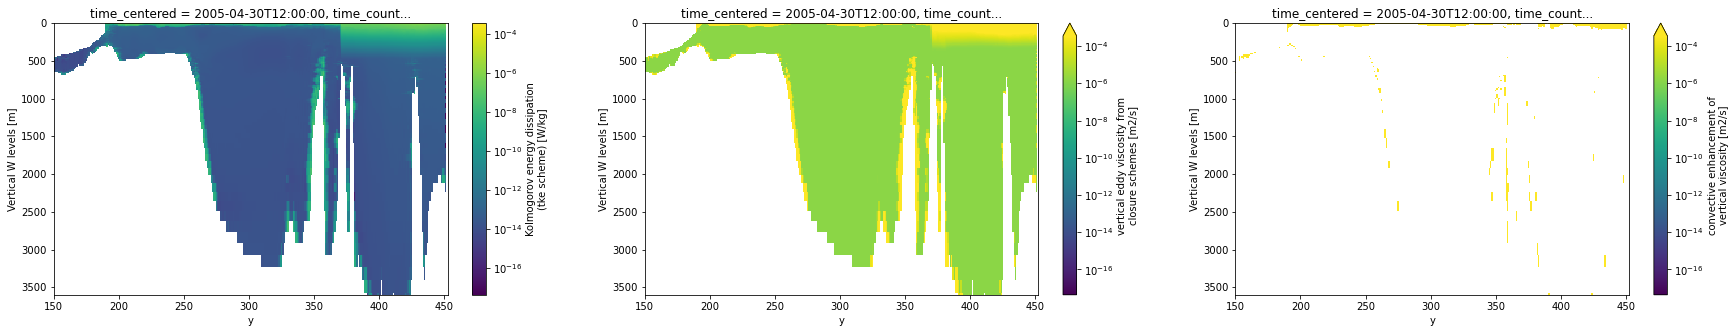

In [58]:
fig, ax = plt.subplots(1,3, figsize=(30, 5))
kwags= {'norm':colors.LogNorm(), 'ylim':(3600,0), 'xlim':(150,None)}
sub={'time_counter':0, 'x':940}
ds.ediss_k.where(ds.ediss_k>0).isel(**sub).plot(ax=ax[0],  **kwags)
ds.avm_k.where(ds.avm_k!=0).isel(**sub).plot(ax=ax[1], **kwags)
ds.avm_evd.where(ds.avm_evd!=0).isel(**sub).plot(ax=ax[2], **kwags)

# Estimate cabbeling
- for each cell calculate current density minus density if it were to mix with the cell below it
- for each cell calculate how its density changed relative to the previous time step

In [82]:
run_dir = f'{base_dir}output/ERA5_test6_highres/files2/'
file = glob.glob(f'{run_dir}eANT025*grid_T*')[0]
dsT  = xr.open_dataset(file).squeeze()
mesh = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0)
temp = xr.where(mesh.tmask.values==0, np.nan, dsT.thetao)
salt = xr.where(mesh.tmask.values==0, np.nan, dsT.so)

In [83]:
rho = gsw.density.rho(salt, temp, temp.deptht) # nemo_mesh_ds.deptht

In [84]:
salt_shifted = (salt).shift(deptht=-1) # calculate salt/m2 before shifting the layers
temp_shifted = (temp).shift(deptht=-1)

In [87]:
# temperature and salt of mixture needs to be weighted by the grid cell volume (but since they're at the same location, realistically only the depht)
new_salt = (salt + salt_shifted)/2
new_temp = (temp + temp_shifted)/2
# calculate new density
new_rho  = gsw.density.rho(new_salt, new_temp, temp.deptht)
cabbel_potential = new_rho - ((rho+rho.shift(deptht=-1))/2)

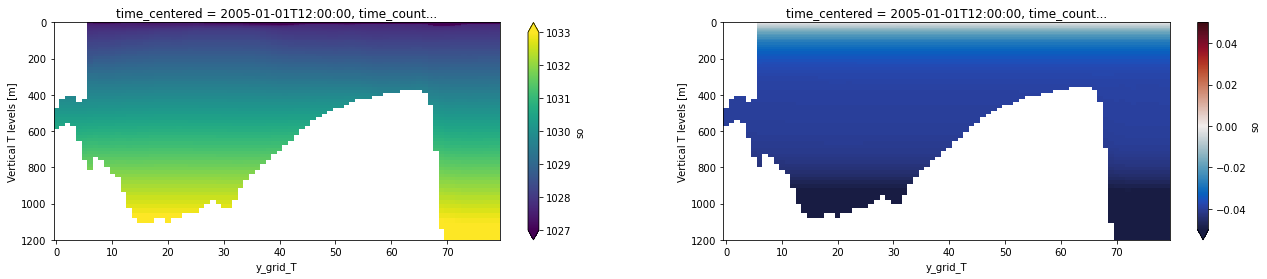

In [90]:
fig, ax = plt.subplots(1,2, figsize=(22, 4))
rho.isel(x_grid_T=1000, y_grid_T=slice(160,240)).plot(ax=ax[0], ylim=(1200,0), vmin=1027, vmax=1033)
cabbel_potential.isel(x_grid_T=1000, y_grid_T=slice(160,240)).plot(ax=ax[1], ylim=(1200,0), vmin=-0.05, vmax=0.05, cmap=cmocean.cm.balance)

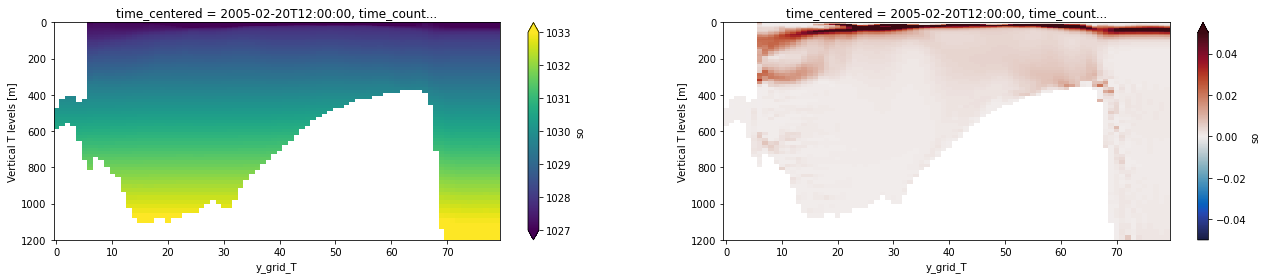

In [70]:
fig, ax = plt.subplots(1,2, figsize=(22, 4))
rho.isel(x_grid_T=1000, y_grid_T=slice(160,240)).plot(ax=ax[0], ylim=(1200,0), vmin=1027, vmax=1033)
cabbel_potential.isel(x_grid_T=1000, y_grid_T=slice(160,240)).plot(ax=ax[1], ylim=(1200,0), vmin=-0.05, vmax=0.05, cmap=cmocean.cm.balance)

## Drift in surface salinity and temperature?

- ERA5_evd_test1 --- change evd convection rate from 10 to 2
- ERA5_evd_test2 --- switch convection to only on tracer not on momentum
- ERA5_evd_test3 --- ln_zad_Aimp off
- ERA5_evd_test4 --- turn on logarithmic form drag (instead of non-linear)
- ERA5_evd_test5 --- evd off amd replaced with ln_tranpc

In [57]:
def plot_surface_drift(run_dirs, labels, region, nemo_mesh='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):

    if region=='Tarkan':
        x_slice=slice(1132,1265)
        y_slice=slice(310,365)
    elif region=='Weddell':
        x_slice=weddell_basin['x']
        y_slice=weddell_basin['y']
    
    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=x_slice, y=y_slice).isel(nav_lev=0)
    
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    for r, run_dir in enumerate(run_dirs):
    
        if r==0 or r==2:
            files = glob.glob(f'{run_dir}files_spinup/eANT025*grid_T*') 
        else:
            files = glob.glob(f'{run_dir}files/eANT025*grid_T*') 
        
        kwags={'preprocess':lambda ds: ds[['sosss', 'sosst', 'area_grid_T', 'time_counter']], 'chunks':'auto'}
        nemo_ds    = xr.open_mfdataset(files, **kwags).rename({'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area'})
        nemo_ds    = nemo_ds.isel(x=x_slice, y=y_slice) 
        area_ocean = xr.where(nemo_mesh_ds.tmask==0, np.nan, nemo_ds['area'])
        
        T_ocean  = xr.where(nemo_mesh_ds.tmask==0, np.nan, nemo_ds['sosst'])
        S_ocean  = xr.where(nemo_mesh_ds.tmask==0, np.nan, nemo_ds['sosss'])
    
        for v, var_ocean in enumerate([S_ocean, T_ocean]):
            region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
            region_max = region_var.groupby('time_counter.year').max()
    
            ax[v].plot(region_max.year, region_max, label=labels[r])
    
    ax[0].set_title(f'{region} box averaged annual maximum')
    ax[0].set_ylabel('Absolute surface salinity')
    ax[1].set_ylabel('Conservative surface temperature')
    ax[0].legend()
    
    return fig, ax

In [58]:
run_dirs = [f'{base_dir}output/ERA5_test6/', f'{base_dir}output/ERA5_test6/', f'{base_dir}output/ERA5_test7/', f'{base_dir}output/ERA5_test7/', 
            f'{base_dir}output/ERA5_evd_test1/', f'{base_dir}output/ERA5_evd_test2/', f'{base_dir}output/ERA5_evd_test3/',
            f'{base_dir}output/ERA5_evd_test4/', f'{base_dir}output/ERA5_evd_test5/']
labels  = ['ERA5_test6 spin up', 'ERA5_test6', 'ERA5_test7 spin up', 'ERA5_test7', 'ERA5_evd_test1', 
           'ERA5_evd_test2', 'ERA5_evd_test3', 'ERA5_evd_test4', 'ERA5_evd_test5']

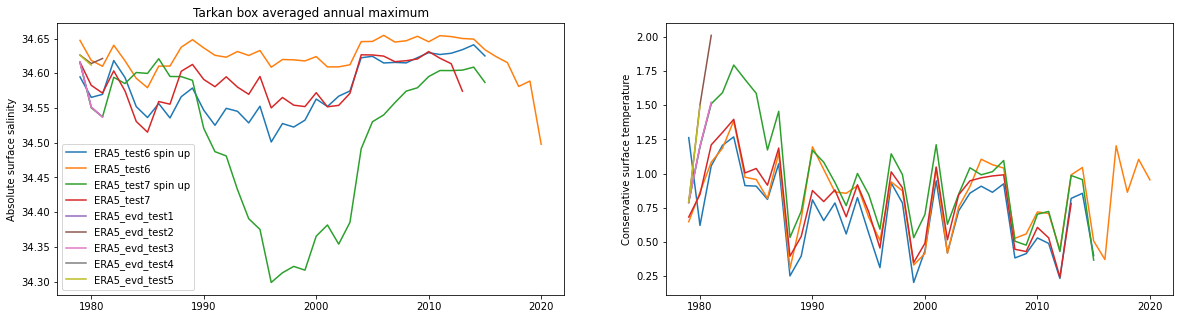

In [59]:
fig1, ax1 = plot_surface_drift(run_dirs, labels, 'Tarkan')

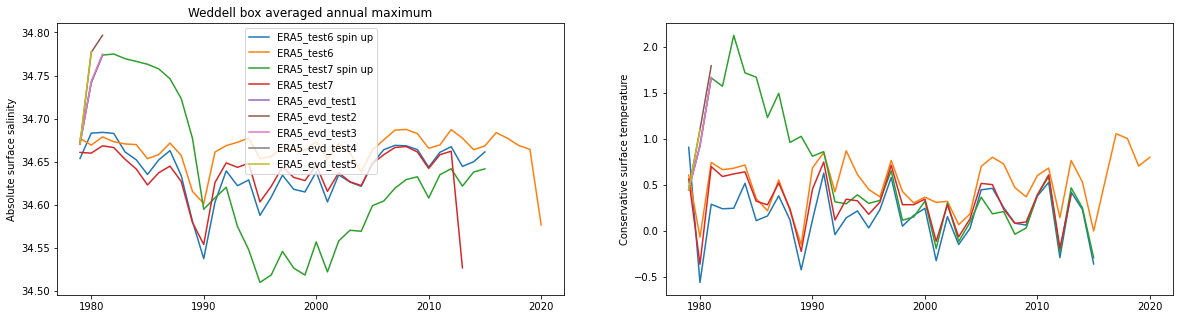

In [60]:
fig2, ax2 = plot_surface_drift(run_dirs, labels, 'Weddell')